### Prophet Model

In [ ]:
#Install prophet package. 
%pip install prophet

In [324]:
#import necessary libraries 
import pandas as pd
from prophet import Prophet 
from prophet.diagnostics import cross_validation, performance_metrics
#to mute Pandas warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



In [325]:
#load data
final_data = pd.read_csv('../data/final_data_2010_2021.csv')
final_data.head()

,DATETIME,TOTALDEMAND,TEMPERATURE,DAYOFWEEK,HOUR,MONTH,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY
0,2010-01-01 00:00:00,8038.00,23.1,4,0,1,1,0,0,0,0,1,1
1,2010-01-01 00:30:00,7809.31,22.9,4,0,1,1,0,0,0,0,1,1
2,2010-01-01 01:00:00,7483.69,22.6,4,1,1,1,0,0,0,0,1,1
3,2010-01-01 01:30:00,7117.23,22.5,4,1,1,1,0,0,0,0,1,1
4,2010-01-01 02:00:00,6812.03,22.5,4,2,1,1,0,0,0,0,1,1


In [326]:
final_data.tail()

,DATETIME,TOTALDEMAND,TEMPERATURE,DAYOFWEEK,HOUR,MONTH,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY
196508,2021-03-17 22:00:00,7419.77,19.7,2,22,3,0,1,0,0,1,1,0
196509,2021-03-17 22:30:00,7417.91,19.5,2,22,3,0,1,0,0,1,1,0
196510,2021-03-17 23:00:00,7287.32,19.1,2,23,3,0,1,0,0,0,1,0
196511,2021-03-17 23:30:00,7172.39,18.8,2,23,3,0,1,0,0,0,1,0
196512,2021-03-18 00:00:00,7094.51,18.6,3,0,3,0,1,0,0,0,1,0


In [327]:
#remove the last row
final_data = final_data[:-1]


In [328]:
final_data.tail()

,DATETIME,TOTALDEMAND,TEMPERATURE,DAYOFWEEK,HOUR,MONTH,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY
196507,2021-03-17 21:30:00,7503.12,19.7,2,21,3,0,1,0,0,1,1,0
196508,2021-03-17 22:00:00,7419.77,19.7,2,22,3,0,1,0,0,1,1,0
196509,2021-03-17 22:30:00,7417.91,19.5,2,22,3,0,1,0,0,1,1,0
196510,2021-03-17 23:00:00,7287.32,19.1,2,23,3,0,1,0,0,0,1,0
196511,2021-03-17 23:30:00,7172.39,18.8,2,23,3,0,1,0,0,0,1,0


#### Data preparation for the model

In [329]:
df = final_data.copy()
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df.dtypes

DATETIME       datetime64[ns]
TOTALDEMAND           float64
TEMPERATURE           float64
DAYOFWEEK               int64
HOUR                    int64
MONTH                   int64
SUMMER                  int64
AUTUMN                  int64
WINTER                  int64
SPRING                  int64
PEAK                    int64
WEEKDAY                 int64
HOLIDAY                 int64
dtype: object

In [330]:
#changing the data type of the columns to boolean
df['SUMMER'] = df['SUMMER'].astype('bool')
df['AUTUMN'] = df['AUTUMN'].astype('bool')
df['WINTER'] = df['WINTER'].astype('bool')
df['SPRING'] = df['SPRING'].astype('bool')
df['HOLIDAY'] = df['HOLIDAY'].astype('bool')
df['WEEKDAY'] = df['WEEKDAY'].astype('bool')
df['PEAK'] = df['PEAK'].astype('bool')
#DAYOFWEEK, HOUR and MONTH to one-hot encoded
df = pd.get_dummies(df, columns=['DAYOFWEEK'])
df = pd.get_dummies(df, columns=['HOUR'])
df = pd.get_dummies(df, columns=['MONTH'])

In [331]:
df.dtypes

DATETIME       datetime64[ns]
TOTALDEMAND           float64
TEMPERATURE           float64
SUMMER                   bool
AUTUMN                   bool
WINTER                   bool
SPRING                   bool
PEAK                     bool
WEEKDAY                  bool
HOLIDAY                  bool
DAYOFWEEK_0              bool
DAYOFWEEK_1              bool
DAYOFWEEK_2              bool
DAYOFWEEK_3              bool
DAYOFWEEK_4              bool
DAYOFWEEK_5              bool
DAYOFWEEK_6              bool
HOUR_0                   bool
HOUR_1                   bool
HOUR_2                   bool
HOUR_3                   bool
HOUR_4                   bool
HOUR_5                   bool
HOUR_6                   bool
HOUR_7                   bool
HOUR_8                   bool
HOUR_9                   bool
HOUR_10                  bool
HOUR_11                  bool
HOUR_12                  bool
HOUR_13                  bool
HOUR_14                  bool
HOUR_15                  bool
HOUR_16   

In [332]:
df.head()

,DATETIME,TOTALDEMAND,TEMPERATURE,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,2010-01-01 00:00:00,8038.00,23.1,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,2010-01-01 00:30:00,7809.31,22.9,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,2010-01-01 01:00:00,7483.69,22.6,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
3,2010-01-01 01:30:00,7117.23,22.5,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
4,2010-01-01 02:00:00,6812.03,22.5,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False


In [333]:
df.columns

Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'SUMMER', 'AUTUMN', 'WINTER',
       'SPRING', 'PEAK', 'WEEKDAY', 'HOLIDAY', 'DAYOFWEEK_0', 'DAYOFWEEK_1',
       'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4', 'DAYOFWEEK_5',
       'DAYOFWEEK_6', 'HOUR_0', 'HOUR_1', 'HOUR_2', 'HOUR_3', 'HOUR_4',
       'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11',
       'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17',
       'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'],
      dtype='object')

In [334]:
#keep rows from 2018-01-01 
df = df[(df['DATETIME'] >= '2018-01-01')]
df

,DATETIME,TOTALDEMAND,TEMPERATURE,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
140256,2018-01-01 00:00:00,7034.74,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
140257,2018-01-01 00:30:00,6912.25,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
140258,2018-01-01 01:00:00,6745.63,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
140259,2018-01-01 01:30:00,6466.06,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
140260,2018-01-01 02:00:00,6279.80,22.3,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196507,2021-03-17 21:30:00,7503.12,19.7,False,True,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
196508,2021-03-17 22:00:00,7419.77,19.7,False,True,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
196509,2021-03-17 22:30:00,7417.91,19.5,False,True,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
196510,2021-03-17 23:00:00,7287.32,19.1,False,True,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False


In [335]:
df.tail()

,DATETIME,TOTALDEMAND,TEMPERATURE,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
196507,2021-03-17 21:30:00,7503.12,19.7,False,True,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
196508,2021-03-17 22:00:00,7419.77,19.7,False,True,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
196509,2021-03-17 22:30:00,7417.91,19.5,False,True,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
196510,2021-03-17 23:00:00,7287.32,19.1,False,True,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
196511,2021-03-17 23:30:00,7172.39,18.8,False,True,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False


In [336]:
# Prophet requires column names to be 'ds' and 'y' so we need to rename the columns
df = df.rename(columns={'DATETIME': 'ds', 'TOTALDEMAND': 'y'})
df.head()

,ds,y,TEMPERATURE,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
140256,2018-01-01 00:00:00,7034.74,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
140257,2018-01-01 00:30:00,6912.25,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
140258,2018-01-01 01:00:00,6745.63,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
140259,2018-01-01 01:30:00,6466.06,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
140260,2018-01-01 02:00:00,6279.80,22.3,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False


In [337]:
#split data into training and test sets 0.8/0.2
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [338]:
#make ds a datetime object
train['ds'] = pd.to_datetime(train['ds'])
test['ds'] = pd.to_datetime(test['ds'])

/var/folders/vr/sx0pb6yj5415ch82cprw5jxc0000gn/T/ipykernel_59493/1655205427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_datetime(train['ds'])
/var/folders/vr/sx0pb6yj5415ch82cprw5jxc0000gn/T/ipykernel_59493/1655205427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])


In [339]:
test.dtypes, train.dtypes

(ds             datetime64[ns]
 y                     float64
 TEMPERATURE           float64
 SUMMER                   bool
 AUTUMN                   bool
 WINTER                   bool
 SPRING                   bool
 PEAK                     bool
 WEEKDAY                  bool
 HOLIDAY                  bool
 DAYOFWEEK_0              bool
 DAYOFWEEK_1              bool
 DAYOFWEEK_2              bool
 DAYOFWEEK_3              bool
 DAYOFWEEK_4              bool
 DAYOFWEEK_5              bool
 DAYOFWEEK_6              bool
 HOUR_0                   bool
 HOUR_1                   bool
 HOUR_2                   bool
 HOUR_3                   bool
 HOUR_4                   bool
 HOUR_5                   bool
 HOUR_6                   bool
 HOUR_7                   bool
 HOUR_8                   bool
 HOUR_9                   bool
 HOUR_10                  bool
 HOUR_11                  bool
 HOUR_12                  bool
 HOUR_13                  bool
 HOUR_14                  bool
 HOUR_15

In [340]:
train.shape, test.shape

((45004, 53), (11252, 53))

In [341]:
print(f"Number of rows in train data: {len(train)}")
print(f"Number of rows in test data: {len(test)}")

Number of rows in train data: 45004
Number of rows in test data: 11252


#### Holiday

In [342]:
import holidays

# Define NSW holidays for 10 years
nsw_holidays = holidays.Australia(years=range(2010, 2020), prov='NSW')

# Get all holidays for New South Wales
holiday_list = list(nsw_holidays.items())

# Convert holiday dates to a DataFrame
holiday_dates = pd.DataFrame(holiday_list, columns=['Date', 'Holiday_Name'])

# Convert holiday dates to datetime.date type 
holiday_dates['Date'] = pd.to_datetime(holiday_dates['Date'])

#Sort the values by date
holiday_dates = holiday_dates.sort_values(by='Date')

#add lower window and upper window for each holiday
holiday_dates['lower_window'] = -1
holiday_dates['upper_window'] = 1


holiday_dates.dtypes

Date            datetime64[ns]
Holiday_Name            object
lower_window             int64
upper_window             int64
dtype: object

In [343]:
holiday_dates

,Date,Holiday_Name,lower_window,upper_window
48,2010-01-01,New Year's Day,-1,1
49,2010-01-26,Australia Day,-1,1
46,2010-04-02,Good Friday,-1,1
50,2010-04-03,Easter Saturday,-1,1
47,2010-04-05,Easter Monday,-1,1
...,...,...,...,...
41,2019-04-25,ANZAC Day,-1,1
43,2019-06-10,Queen's Birthday,-1,1
42,2019-10-07,Labour Day,-1,1
44,2019-12-25,Christmas Day,-1,1


In [344]:
#copy holiday_dates to a new dataframe and keep only the dates from 2018 to 2020
holiday_nsw_2018_2020 = holiday_dates[(holiday_dates['Date'] >= '2018-01-01') & (holiday_dates['Date'] < '2021-01-01')]
#rename the columns to ds and holiday
holiday_nsw_2018_2020 = holiday_nsw_2018_2020.rename(columns={'Date': 'ds', 'Holiday_Name': 'holiday'}) 
holiday_nsw_2018_2020

,ds,holiday,lower_window,upper_window
26,2018-01-01,New Year's Day,-1,1
27,2018-01-26,Australia Day,-1,1
24,2018-03-30,Good Friday,-1,1
28,2018-03-31,Easter Saturday,-1,1
29,2018-04-01,Easter Sunday,-1,1
25,2018-04-02,Easter Monday,-1,1
30,2018-04-25,ANZAC Day,-1,1
32,2018-06-11,Queen's Birthday,-1,1
31,2018-10-01,Labour Day,-1,1
33,2018-12-25,Christmas Day,-1,1


In [345]:
holiday_nsw_2018_2020.dtypes

ds              datetime64[ns]
holiday                 object
lower_window             int64
upper_window             int64
dtype: object

#### Prophet Model

In [346]:
#function for prophet model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# from fbprophet.diagnostics import cross_validation, performance_metrics

# def prophet_model(df, regressors, train_start, train_end, test_start, test_end):
def prophet_model(df, regressors, train, test): 
    #split data
    #train = df[(df['ds'] >= pd.Timestamp(train_start)) & (df['ds'] < pd.Timestamp(train_end))]
    #test = df[(df['ds'] >= pd.Timestamp(test_start)) & (df['ds'] < pd.Timestamp(test_end))]
    
    #initialize model
    model = Prophet(daily_seasonality = True, weekly_seasonality=True, yearly_seasonality=True, holidays=holiday_nsw_2018_2020, holidays_prior_scale=0.1, seasonality_prior_scale=10)
    
    # # Add custom seasonality components
    # model.add_seasonality(
    #     name='yearly', 
    #     period=365.25, 
    #     fourier_order=2,
    #     #prior_scale=0.1,
    #     mode='additive')
    
    # model.add_seasonality(
    #     name='weekly', 
    #     period=7, 
    #     fourier_order=3,
    #     #prior_scale=0.1,
    #     mode='additive')
    
    # model.add_seasonality(
    #     name='daily', 
    #     period=1, 
    #     fourier_order=2,
    #     #prior_scale=5,
    #     mode='additive')
    
    # Add custom quarterly seasonality
    # model.add_seasonality(
    #     name='quarterly',      # Name of the seasonality
    #     period=90.625,         # Approximate length of a quarter (3 months)
    #     fourier_order=10,      # Fourier order for the quarterly seasonality
    #     mode='additive')       # Additive seasonality

    
    
    #add regressors
    # model.add_regressor('TEMPERATURE', prior_scale=20) 
    # model.add_regressor('WEEKDAY', prior_scale=10)
    # model.add_regressor('PEAK', prior_scale=10)
    for regressor in regressors:
        model.add_regressor(regressor, mode='additive')
    
    #fit model
    model.fit(train)
    
    #predict the future
    forecast = model.predict(test)
    
    #copy ds and yhat to a new dataframe
    result = forecast[['ds', 'yhat']]
    #copy y from test to compare dataframe
    result['y'] = test['y'].values
    
    #print model performance
    mse = mean_squared_error(result['y'], result['yhat'])
    rmse = sqrt(mse)
    mae = mean_absolute_error(result['y'], result['yhat'])
    mape = mean_absolute_percentage_error(result['y'], result['yhat'])
    
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Absolute Percentage Error: {mape}')
    
    
    
    #plot actual vs predicted
    plt.figure(figsize=(14, 7))
    plt.plot(result['ds'], result['y'], label='Actual')
    plt.plot(result['ds'], result['yhat'], label='Predicted')
    plt.legend()
    plt.show()
    
    
    return model, result

#### Model 1: Univariate model without regressor

13:43:06 - cmdstanpy - INFO - Chain [1] start processing
13:43:16 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 1824865.78682574
Root Mean Squared Error: 1350.875933172895
Mean Absolute Error: 1148.7726168715892
Mean Absolute Percentage Error: 0.16014947267374938


/var/folders/vr/sx0pb6yj5415ch82cprw5jxc0000gn/T/ipykernel_59493/3096093021.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['y'] = test['y'].values


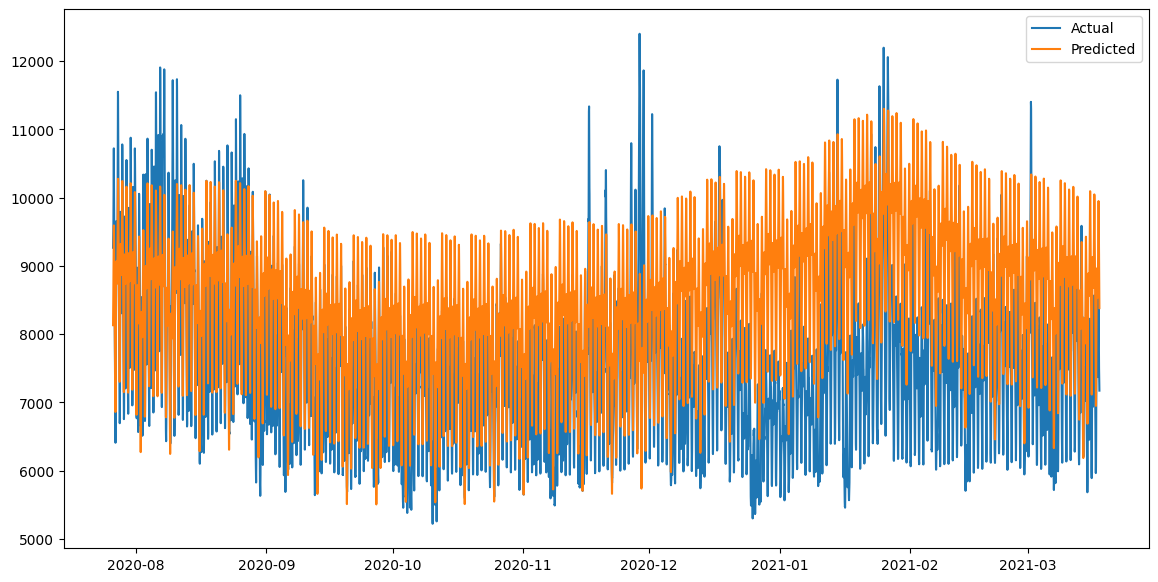

,ds,yhat,y
0,2020-07-26 14:00:00,8131.370565,9266.35
1,2020-07-26 14:30:00,8223.709019,9334.91
2,2020-07-26 15:00:00,8353.203756,9327.67
3,2020-07-26 15:30:00,8521.410274,9385.67
4,2020-07-26 16:00:00,8723.379556,9569.27


In [347]:
#univariate model
regressors = []
model1, result1 = prophet_model(df, regressors, train, test)
result1.head()

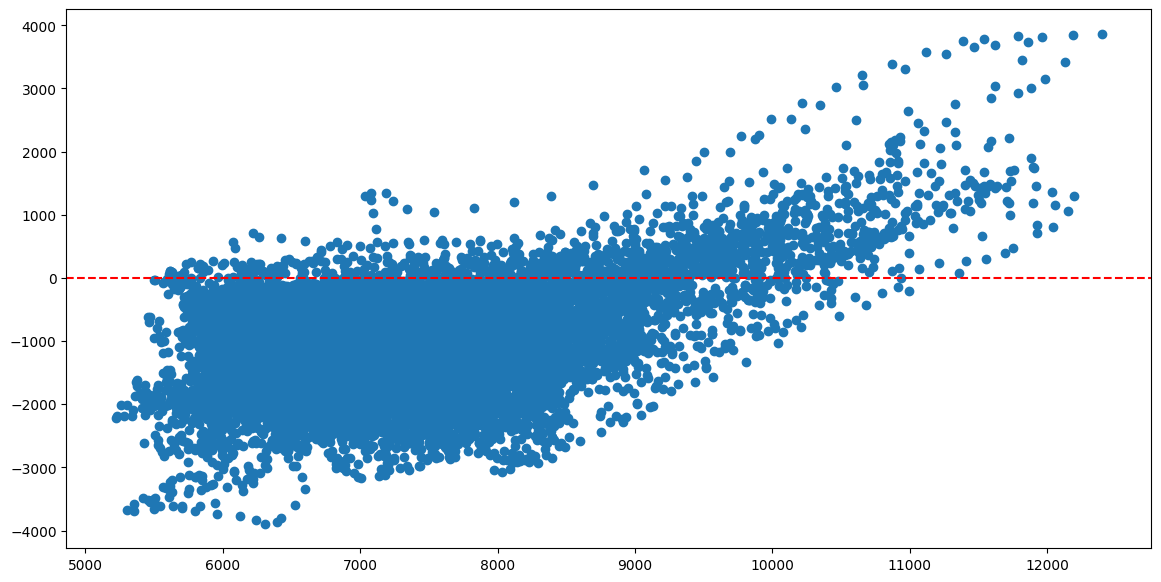

In [348]:
#plot the residuals
plt.figure(figsize=(14, 7))
plt.scatter(result1['y'], result1['y'] - result1['yhat'])
plt.axhline(0, color='red', linestyle='--')
plt.show()

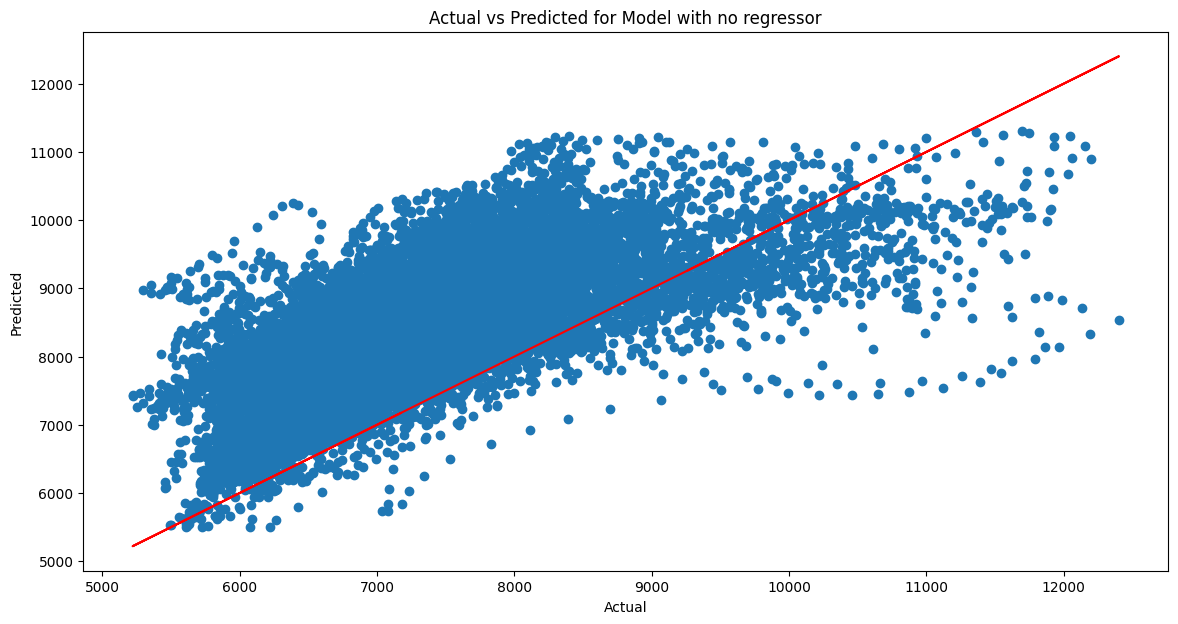

In [349]:
#scatter plot y vs y_hat
plt.figure(figsize=(14, 7))
plt.scatter(result1['y'], result1['yhat'])
plt.plot(result1['y'], result1['y'], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted for Model with no regressor')
plt.show()

In [350]:
df.columns


Index(['ds', 'y', 'TEMPERATURE', 'SUMMER', 'AUTUMN', 'WINTER', 'SPRING',
       'PEAK', 'WEEKDAY', 'HOLIDAY', 'DAYOFWEEK_0', 'DAYOFWEEK_1',
       'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4', 'DAYOFWEEK_5',
       'DAYOFWEEK_6', 'HOUR_0', 'HOUR_1', 'HOUR_2', 'HOUR_3', 'HOUR_4',
       'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11',
       'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17',
       'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'],
      dtype='object')

#### Model 2: Multivariate model with regressors

13:43:23 - cmdstanpy - INFO - Chain [1] start processing
13:43:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 1830694.160380964
Root Mean Squared Error: 1353.0314705804014
Mean Absolute Error: 1148.348048781874
Mean Absolute Percentage Error: 0.1600284130515973


/var/folders/vr/sx0pb6yj5415ch82cprw5jxc0000gn/T/ipykernel_59493/3096093021.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['y'] = test['y'].values


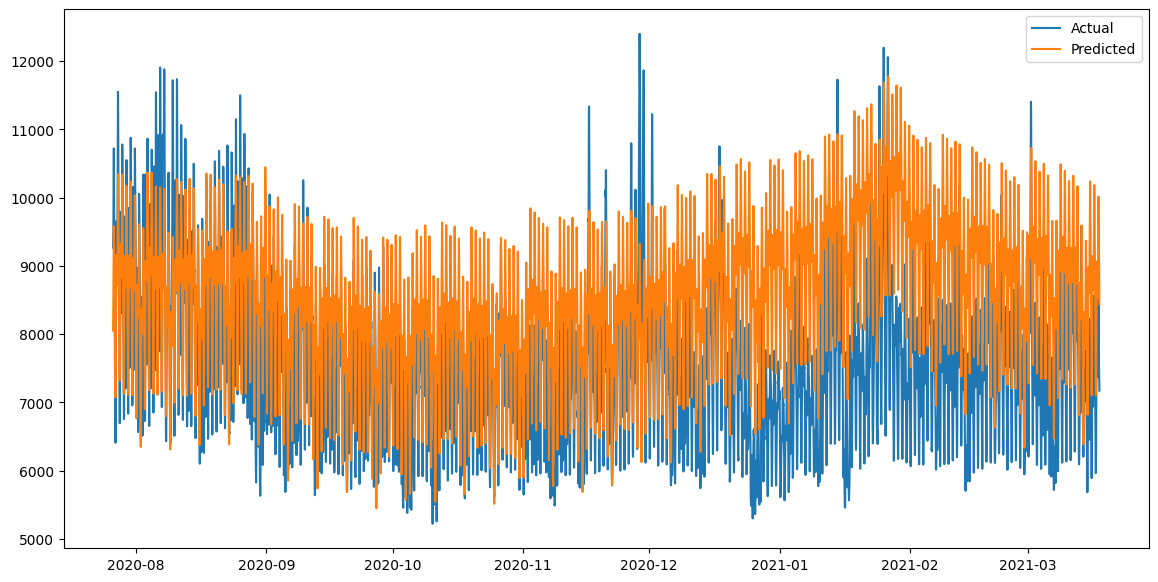

,ds,yhat,y
0,2020-07-26 14:00:00,8052.773246,9266.35
1,2020-07-26 14:30:00,8134.589834,9334.91
2,2020-07-26 15:00:00,8241.287884,9327.67
3,2020-07-26 15:30:00,8396.733582,9385.67
4,2020-07-26 16:00:00,8585.429718,9569.27


In [351]:
regressors = ['TEMPERATURE', 'SUMMER', 'AUTUMN', 'WINTER', 'SPRING',
       'PEAK', 'WEEKDAY', 'HOLIDAY', 'DAYOFWEEK_0', 'DAYOFWEEK_1',
       'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4', 'DAYOFWEEK_5',
       'DAYOFWEEK_6', 'HOUR_0', 'HOUR_1', 'HOUR_2', 'HOUR_3', 'HOUR_4',
       'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11',
       'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17',
       'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12']

model2, result2 = prophet_model(df, regressors, train, test)
result2.head()

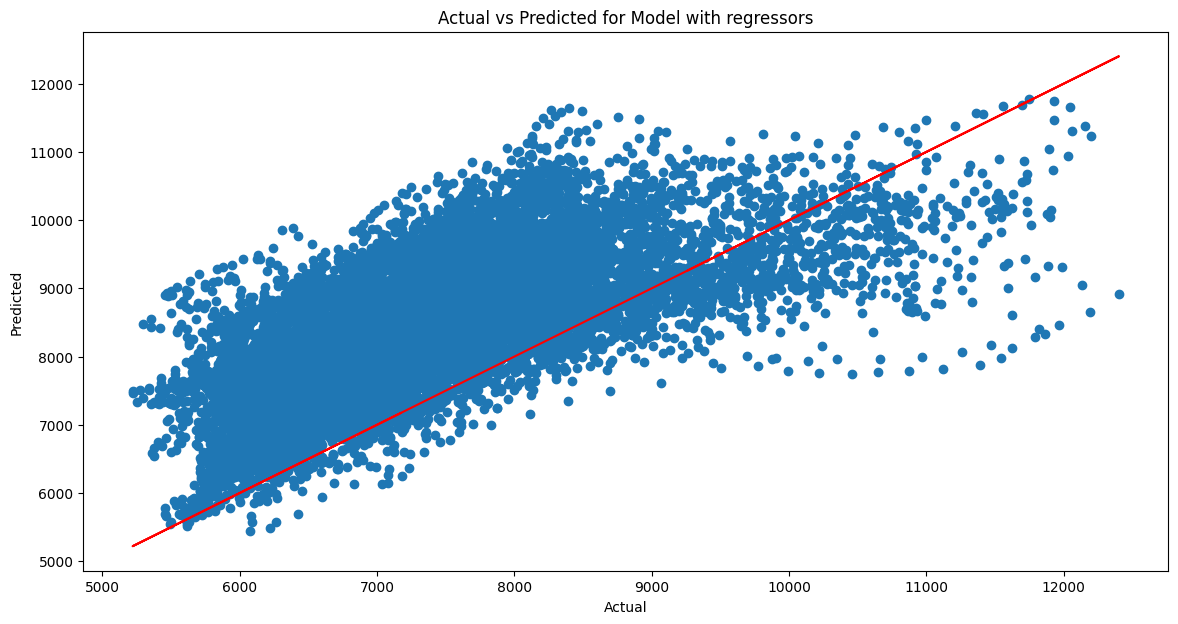

In [352]:
#scatter plot y vs y_hat
plt.figure(figsize=(14, 7))
plt.scatter(result2['y'], result2['yhat'])
plt.plot(result2['y'], result2['y'], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted for Model with regressors')
plt.show()

#### Adding lags

In [353]:
#copy df to a new dataframe and add lag column
df_lag = df.copy()
df_lag['lag_1'] = df_lag['y'].shift(1)
df_lag['lag_2'] = df_lag['y'].shift(2)
df_lag['lag_3'] = df_lag['y'].shift(3)
df_lag

,ds,y,TEMPERATURE,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY,...,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,lag_1,lag_2,lag_3
140256,2018-01-01 00:00:00,7034.74,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,NaN,NaN,NaN
140257,2018-01-01 00:30:00,6912.25,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,7034.74,NaN,NaN
140258,2018-01-01 01:00:00,6745.63,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,6912.25,7034.74,NaN
140259,2018-01-01 01:30:00,6466.06,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,6745.63,6912.25,7034.74
140260,2018-01-01 02:00:00,6279.80,22.3,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,6466.06,6745.63,6912.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196507,2021-03-17 21:30:00,7503.12,19.7,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,7560.98,7735.99,7995.89
196508,2021-03-17 22:00:00,7419.77,19.7,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,7503.12,7560.98,7735.99
196509,2021-03-17 22:30:00,7417.91,19.5,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,7419.77,7503.12,7560.98
196510,2021-03-17 23:00:00,7287.32,19.1,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,7417.91,7419.77,7503.12


In [354]:
df_lag.dtypes

ds             datetime64[ns]
y                     float64
TEMPERATURE           float64
SUMMER                   bool
AUTUMN                   bool
WINTER                   bool
SPRING                   bool
PEAK                     bool
WEEKDAY                  bool
HOLIDAY                  bool
DAYOFWEEK_0              bool
DAYOFWEEK_1              bool
DAYOFWEEK_2              bool
DAYOFWEEK_3              bool
DAYOFWEEK_4              bool
DAYOFWEEK_5              bool
DAYOFWEEK_6              bool
HOUR_0                   bool
HOUR_1                   bool
HOUR_2                   bool
HOUR_3                   bool
HOUR_4                   bool
HOUR_5                   bool
HOUR_6                   bool
HOUR_7                   bool
HOUR_8                   bool
HOUR_9                   bool
HOUR_10                  bool
HOUR_11                  bool
HOUR_12                  bool
HOUR_13                  bool
HOUR_14                  bool
HOUR_15                  bool
HOUR_16   

In [355]:
#replace na with 0
df_lag = df_lag.fillna(0)
df_lag

,ds,y,TEMPERATURE,SUMMER,AUTUMN,WINTER,SPRING,PEAK,WEEKDAY,HOLIDAY,...,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,lag_1,lag_2,lag_3
140256,2018-01-01 00:00:00,7034.74,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,0.00,0.00,0.00
140257,2018-01-01 00:30:00,6912.25,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,7034.74,0.00,0.00
140258,2018-01-01 01:00:00,6745.63,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,6912.25,7034.74,0.00
140259,2018-01-01 01:30:00,6466.06,22.4,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,6745.63,6912.25,7034.74
140260,2018-01-01 02:00:00,6279.80,22.3,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,6466.06,6745.63,6912.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196507,2021-03-17 21:30:00,7503.12,19.7,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,7560.98,7735.99,7995.89
196508,2021-03-17 22:00:00,7419.77,19.7,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,7503.12,7560.98,7735.99
196509,2021-03-17 22:30:00,7417.91,19.5,False,True,False,False,True,True,False,...,False,False,False,False,False,False,False,7419.77,7503.12,7560.98
196510,2021-03-17 23:00:00,7287.32,19.1,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,7417.91,7419.77,7503.12


#### Model 3: Multivariate model with regressors including lag

In [356]:
#split data into training and test sets 0.8/0.2
train_lag_size = int(len(df_lag) * 0.8)
train_lag = df_lag[:train_lag_size]
test_lag = df_lag[train_lag_size:]

train_lag.head(), test_lag.head()

(                        ds        y  TEMPERATURE  SUMMER  AUTUMN  WINTER  \
 140256 2018-01-01 00:00:00  7034.74         22.4    True   False   False   
 140257 2018-01-01 00:30:00  6912.25         22.4    True   False   False   
 140258 2018-01-01 01:00:00  6745.63         22.4    True   False   False   
 140259 2018-01-01 01:30:00  6466.06         22.4    True   False   False   
 140260 2018-01-01 02:00:00  6279.80         22.3    True   False   False   
 
         SPRING   PEAK  WEEKDAY  HOLIDAY  ...  MONTH_6  MONTH_7  MONTH_8  \
 140256   False  False     True     True  ...    False    False    False   
 140257   False  False     True     True  ...    False    False    False   
 140258   False  False     True     True  ...    False    False    False   
 140259   False  False     True     True  ...    False    False    False   
 140260   False  False     True     True  ...    False    False    False   
 
         MONTH_9  MONTH_10  MONTH_11  MONTH_12    lag_1    lag_2    lag_3  
 1

In [357]:
#change train_copy and test_copy to datetime
train_lag['ds'] = pd.to_datetime(train_lag['ds'])
test_lag['ds'] = pd.to_datetime(test_lag['ds'])

/var/folders/vr/sx0pb6yj5415ch82cprw5jxc0000gn/T/ipykernel_59493/2574924660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_lag['ds'] = pd.to_datetime(train_lag['ds'])
/var/folders/vr/sx0pb6yj5415ch82cprw5jxc0000gn/T/ipykernel_59493/2574924660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lag['ds'] = pd.to_datetime(test_lag['ds'])


In [358]:
df_lag.columns

Index(['ds', 'y', 'TEMPERATURE', 'SUMMER', 'AUTUMN', 'WINTER', 'SPRING',
       'PEAK', 'WEEKDAY', 'HOLIDAY', 'DAYOFWEEK_0', 'DAYOFWEEK_1',
       'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4', 'DAYOFWEEK_5',
       'DAYOFWEEK_6', 'HOUR_0', 'HOUR_1', 'HOUR_2', 'HOUR_3', 'HOUR_4',
       'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11',
       'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17',
       'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12',
       'lag_1', 'lag_2', 'lag_3'],
      dtype='object')

13:43:54 - cmdstanpy - INFO - Chain [1] start processing
13:44:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 18192.627593637575
Root Mean Squared Error: 134.88004890878997
Mean Absolute Error: 98.58183608003559
Mean Absolute Percentage Error: 0.013014889528673221


/var/folders/vr/sx0pb6yj5415ch82cprw5jxc0000gn/T/ipykernel_59493/3096093021.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['y'] = test['y'].values


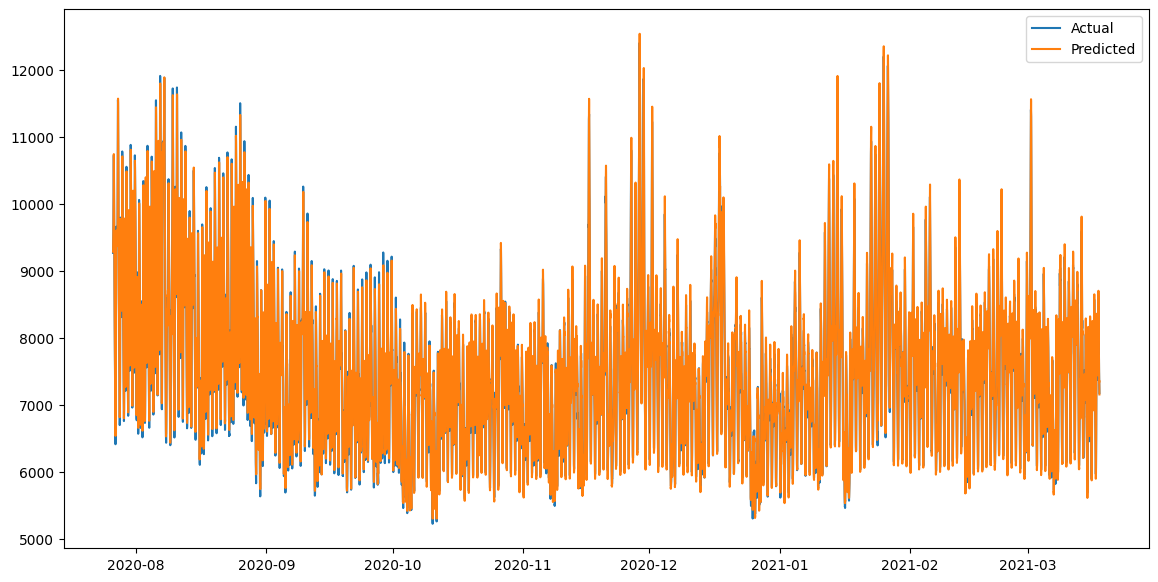

,ds,yhat,y
0,2020-07-26 14:00:00,9284.225201,9266.35
1,2020-07-26 14:30:00,9310.221024,9334.91
2,2020-07-26 15:00:00,9428.943655,9327.67
3,2020-07-26 15:30:00,9448.714198,9385.67
4,2020-07-26 16:00:00,9566.920741,9569.27


In [359]:
regressors_lag = ['TEMPERATURE','SUMMER', 'AUTUMN', 'WINTER', 'SPRING', 
       'WEEKDAY', 'HOLIDAY', 'DAYOFWEEK_0', 'DAYOFWEEK_1',
       'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4', 'DAYOFWEEK_5',
       'DAYOFWEEK_6', 'HOUR_0', 'HOUR_1', 'HOUR_2', 'HOUR_3', 'HOUR_4',
       'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11',
       'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17',
       'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'lag_1']

#call the function
model3, result3 = prophet_model(df_lag, regressors_lag, train_lag, test_lag)
result3.head()

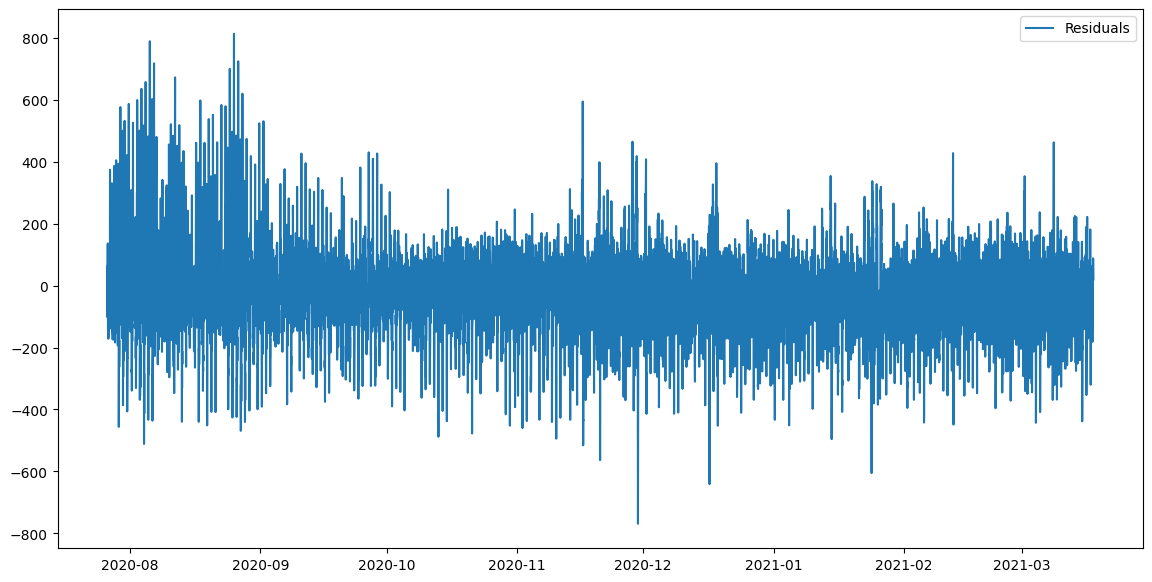

In [360]:
#plot residuals
plt.figure(figsize=(14, 7))
plt.plot(result3['ds'], result3['y'] - result3['yhat'], label='Residuals')
plt.legend()
plt.show()


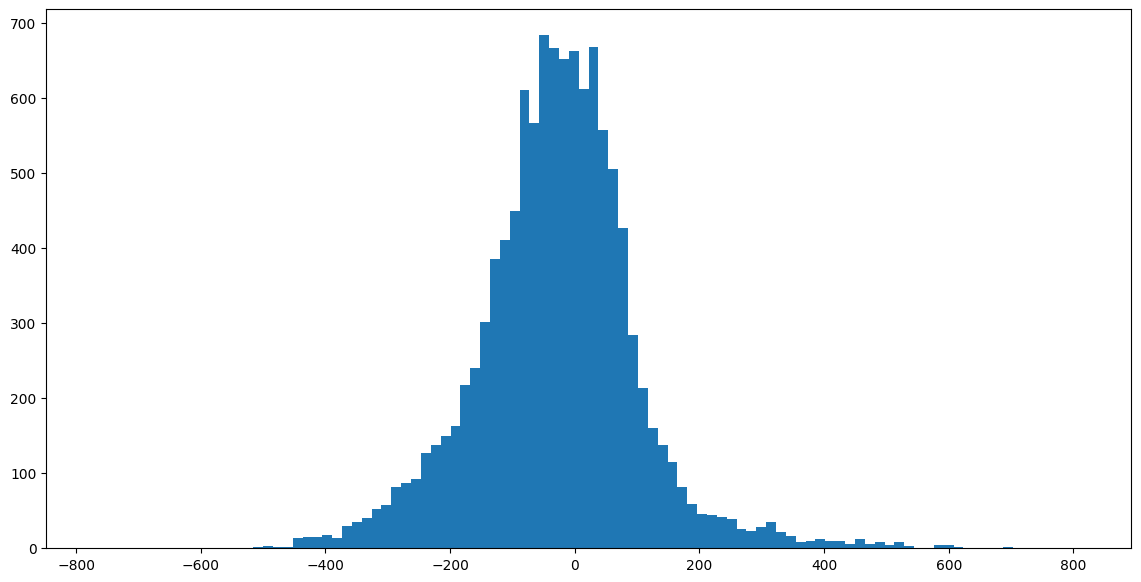

In [361]:
#histogram of residuals
plt.figure(figsize=(14, 7))
plt.hist(result3['y'] - result3['yhat'], bins=100)
plt.show()

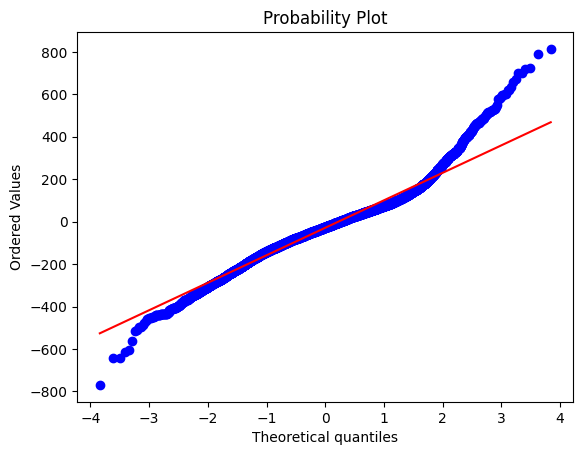

In [362]:
#plot qq plot
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(result3['y'] - result3['yhat'], dist="norm", plot=plt)
plt.show()

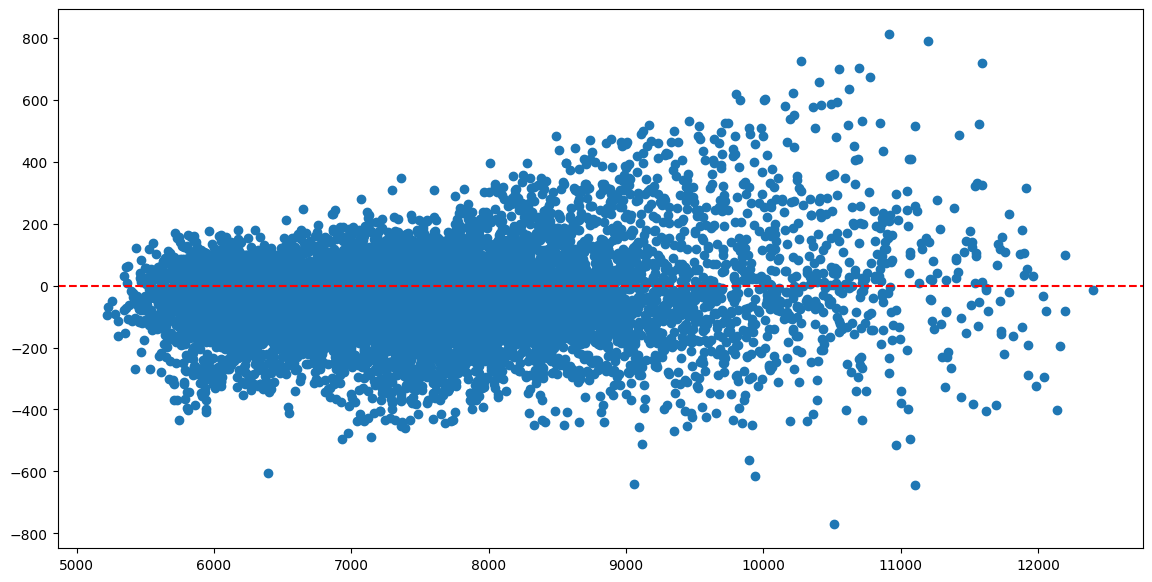

In [363]:
#plot the residuals
plt.figure(figsize=(14, 7))
plt.scatter(result3['y'], result3['y'] - result3['yhat'])
plt.axhline(0, color='red', linestyle='--')
plt.show()

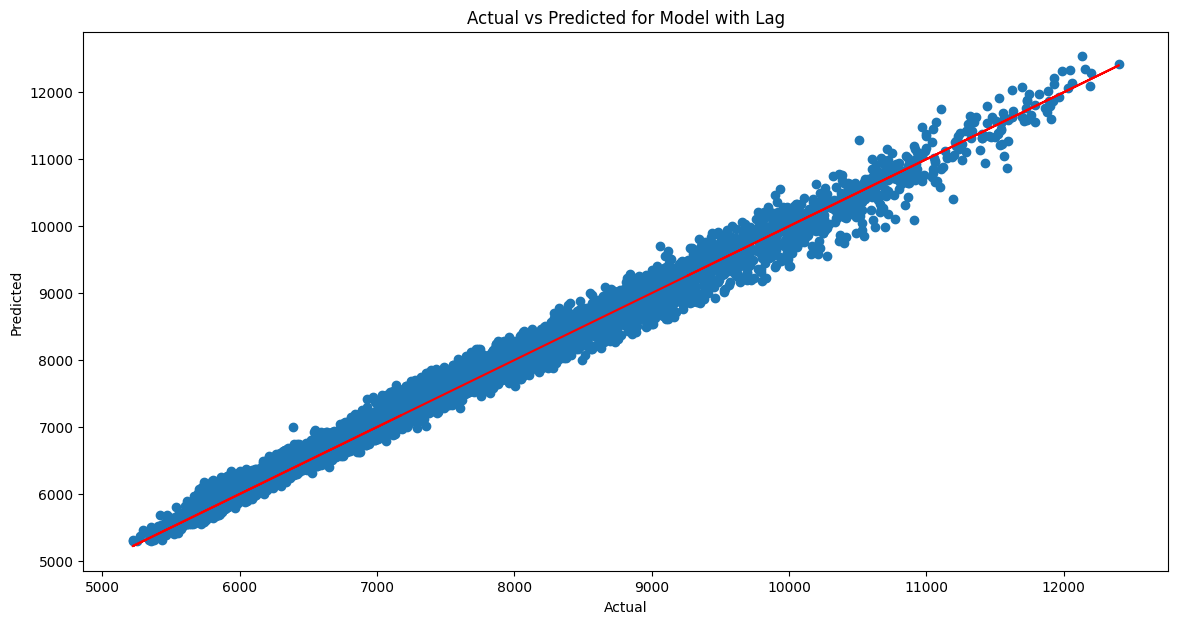

In [364]:
#scatter plot y vs y_hat
plt.figure(figsize=(14, 7))
plt.scatter(result3['y'], result3['yhat'])
plt.plot(result3['y'], result3['y'], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted for Model with Lag')
plt.show()

#### Model 4: Multivariate model with regressors and 3 lags 

13:44:13 - cmdstanpy - INFO - Chain [1] start processing
13:44:29 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 12130.29853346898
Root Mean Squared Error: 110.13763450096874
Mean Absolute Error: 87.43694696454783
Mean Absolute Percentage Error: 0.011785102816724607


/var/folders/vr/sx0pb6yj5415ch82cprw5jxc0000gn/T/ipykernel_59493/3096093021.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['y'] = test['y'].values


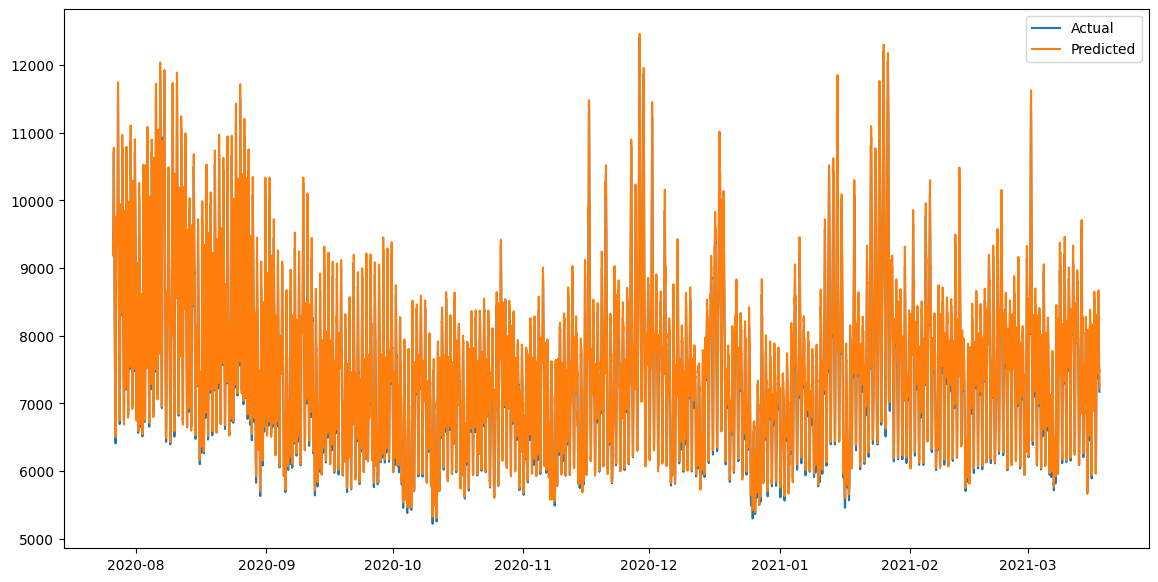

,ds,yhat,y
0,2020-07-26 14:00:00,9188.036847,9266.35
1,2020-07-26 14:30:00,9244.410529,9334.91
2,2020-07-26 15:00:00,9403.455385,9327.67
3,2020-07-26 15:30:00,9342.809475,9385.67
4,2020-07-26 16:00:00,9487.334243,9569.27


In [365]:
regressors_lag = ['TEMPERATURE','SUMMER', 'AUTUMN', 'WINTER', 'SPRING', 
       'WEEKDAY', 'HOLIDAY', 'DAYOFWEEK_0', 'DAYOFWEEK_1',
       'DAYOFWEEK_2', 'DAYOFWEEK_3', 'DAYOFWEEK_4', 'DAYOFWEEK_5',
       'DAYOFWEEK_6', 'HOUR_0', 'HOUR_1', 'HOUR_2', 'HOUR_3', 'HOUR_4',
       'HOUR_5', 'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11',
       'HOUR_12', 'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17',
       'HOUR_18', 'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'lag_1', 'lag_2', 'lag_3']

#call the function
model4, result4 = prophet_model(df_lag, regressors_lag, train_lag, test_lag)
result4.head()

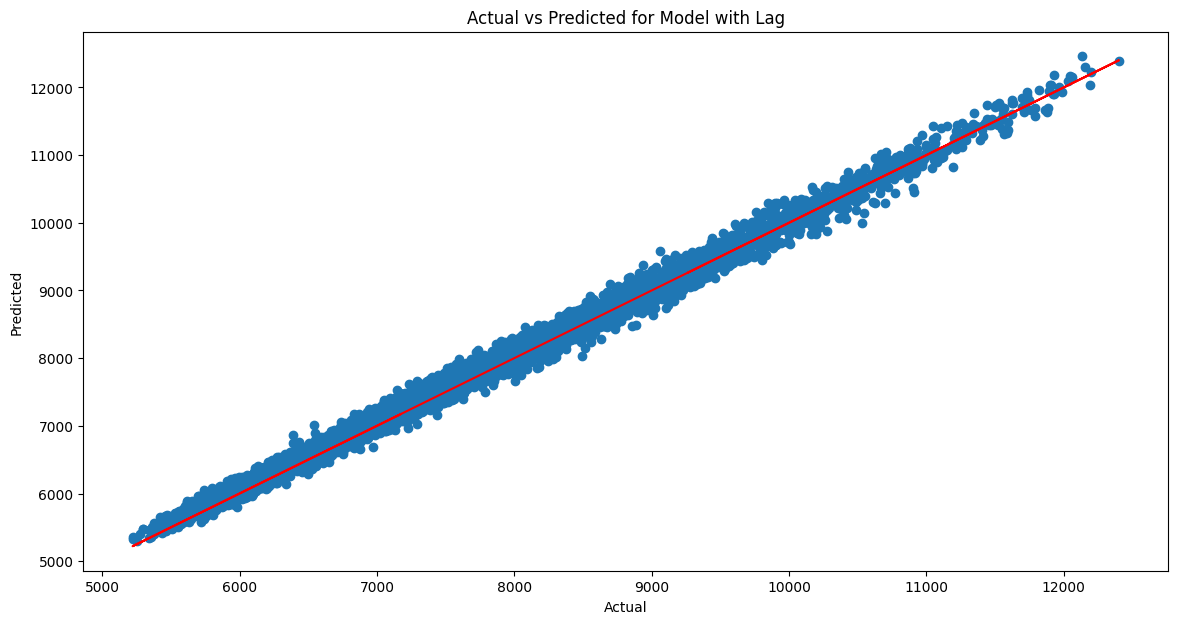

In [366]:
#scatter plot y vs y_hat
plt.figure(figsize=(14, 7))
plt.scatter(result4['y'], result4['yhat'])
plt.plot(result4['y'], result4['y'], color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted for Model with Lag')
plt.show()

#### Result comaprison

In [368]:
#create a table with all the results
results_data = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'MAPE'])
results_data.loc[0] = ['Model 1', mean_squared_error(result1['y'], result1['yhat']), sqrt(mean_squared_error(result1['y'], result1['yhat'])), mean_absolute_error(result1['y'], result1['yhat']), mean_absolute_percentage_error(result1['y'], result1['yhat'])]

results_data.loc[1] = ['Model 2', mean_squared_error(result2['y'], result2['yhat']), sqrt(mean_squared_error(result2['y'], result2['yhat'])), mean_absolute_error(result2['y'], result2['yhat']), mean_absolute_percentage_error(result2['y'], result2['yhat'])]

results_data.loc[2] = ['Model 3', mean_squared_error(result3['y'], result3['yhat']), sqrt(mean_squared_error(result3['y'], result3['yhat'])), mean_absolute_error(result3['y'], result3['yhat']), mean_absolute_percentage_error(result3['y'], result3['yhat'])]

results_data.loc[3] = ['Model 4', mean_squared_error(result4['y'], result3['yhat']), sqrt(mean_squared_error(result3['y'], result3['yhat'])), mean_absolute_error(result3['y'], result3['yhat']), mean_absolute_percentage_error(result4['y'], result4['yhat'])]

results_data

,Model,MSE,RMSE,MAE,MAPE
0,Model 1,1.824866e+06,1350.875933,1148.772617,0.160149
1,Model 2,1.830694e+06,1353.031471,1148.348049,0.160028
2,Model 3,1.819263e+04,134.880049,98.581836,0.013015
3,Model 4,1.819263e+04,134.880049,98.581836,0.011785
